In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [2]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('../data/category3.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'banchan': 0, 'beer': 1, 'beji': 2, 'beji_t': 3, 'bottle': 4, 'bottle_t': 5, 'empty': 6, 'glass': 7, 'glass_t': 8, 'me': 9, 'me_t': 10, 'perfume': 11, 'soju': 12, 'vita': 13, 'wine': 14, 'wine_t': 15}


In [4]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]


In [5]:
import cv2
print(cv2.__version__)

3.4.2


In [88]:
#SIFT 함수

import cv2
import numpy as np
from matplotlib import pyplot as plt

def SIFT_detection(image):

    return cv2.drawKeypoints(gray,kp,frame)

In [3]:
#이미지 불러오기

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = '../data/image3/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
#         preprocessing_function = SIFT_detection,
        rotation_range=40,
        width_shift_range=0.2,
#         height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
#         preprocessing_function = SIFT_detection,
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 30,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 30,
        class_mode="sparse"
    )

Found 623 images belonging to 16 classes.
Found 147 images belonging to 16 classes.


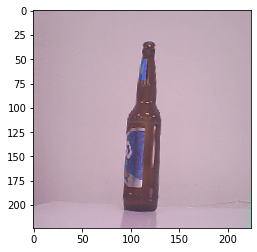

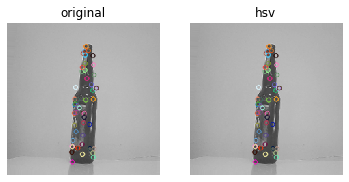

In [12]:
#SIFT 처리 이미지 확인

import numpy as np
import cv2
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

with tf.device('/device:GPU:0'):
    x, y = trainGen.next()

    

    plt.imshow(x[0])
    
    frame =x[0]*255
    frame = frame.astype(np.uint8)

    
    gray= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)

    img=cv2.drawKeypoints(gray,kp,frame)
    
#     img = cv2.resize(img, (255, 255)) 
#     img = img_to_array(img)
#     img = img.standardize(img)
# #     cv.imwrite('sift_keypoints.jpg',img)

    plt.imshow(img)
    

    
#     img=cv.drawKeypoints(gray1,kp,frame,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#     plt.imshow(img)

In [91]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential

with tf.device('/device:GPU:0'):

    VGG16_model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))
    VGG16_model_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [92]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


rootPath = '../data/image3/'


## Pretrained Network
with tf.device('/device:GPU:0'):
    model_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    model_base.trainable = True  # Convolution Layer 완전 동결

    model = Sequential()

    model.add(model_base)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256,
                    activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dense(16,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
   
    
    
        # Model saving callback
    checkpointer = ModelCheckpoint(filepath='../model/recycle_VGG16_image3_1217.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    history = model.fit(trainGen,
                        callbacks=[checkpointer, early_stopping],
                        steps_per_epoch=21,
                        epochs=250,
                        validation_data=validationGen,
                        validation_steps=5,
                        verbose=2)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 16)                4112      
Total params: 14,850,128
Trainable params: 14,850,128
Non-trainable params: 0
_________________________________________________________________


UFuncTypeError: Cannot cast ufunc 'multiply' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

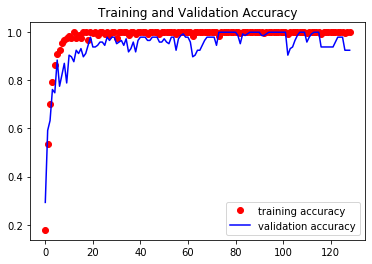

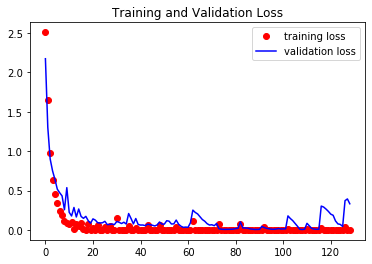

In [22]:
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [208]:
x_train.shape

(30, 224, 224, 3)

[10. 13.  5.  4. 12.  7.  0.  3.  7. 13. 11. 13. 11. 12.  1.  4.  4. 15.
  5.  2. 12.  8.  1.  6.  7. 11.  5. 14.  3.  4.]


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_7/conv2d_17/Conv2D (defined at <ipython-input-13-61b8cc9cb270>:30) ]] [Op:__inference_distributed_function_995]

Function call stack:
distributed_function


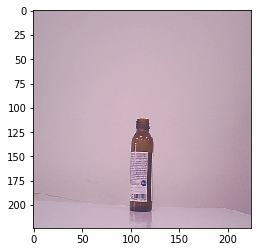

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


#     model_path = '../model/recycle_VGG16_image3_1217.h5'

    model_path = '../model/recycle_cnn_1211.h5'


    vgg_model = tf.keras.models.load_model(model_path)


    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[1])

    #Confution Matrix and Classification Report
    Y_pred = vgg_model.predict(x_train)
    
    print(Y_pred[1])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(15,15))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()